# Convert Phase 2 well data
Locher Environmental recorded data from multiple transducers in two adjacent wells near SLC 39A at Kennedy Space Center (KSC), between March and November, 2022. This was part of a seismo-acoustic erosion pilot experiment. During phase 2 of the experiment, which began on July 21st, 2022, vibrating wire sensors were used and found to give more accurate water levels. These data were captured on Campbell Scientific dataloggers and recorded in TOB3 binary file format. The purpose of this notebook is to:
- read these files
- apply calibration equations
- write to pickle files (Python binary files that serialize the data variables)
Calibration constants are defined in the transducers dataframe (section 2). These are copied from the file "A Pz Linear Gage Calc_NASA Sensors.xls". Other metadata included in this dataframe come from sections 6 and 7 in the file "2022-12-03_ Field Sheet for Deployment of Groundwater Equipment at NASA_Part_II.pdf".

Note on *TIME ZONES*: 
- Local time is used in Campbell Scientific binary files, and files converted to Pickle.
- UTC is used in MiniSEED files, to match seismo-acoustic data.

Note on *UNITS*:
- Pi

To do:
- create a lookup table, matching file name, start time, end time, and SEED trace-ID.


# 1. Imports, path variables, and function definitions

In [3]:
# raw data on April 1, 2022 from 16:10 to 16:40 UTC. Launch from SLC40 at 16:24 UTC, watched from Titusville
import os, sys, glob, obspy
import numpy as np
import pandas as pd
cwd = os.getcwd()
sys.path.append(os.path.join(cwd, 'campbell'))
import read_cs_files as campbell
HOME = os.getenv('HOME')
sys.path.append(os.path.join(HOME, 'src', 'kitchensinkGT', 'LIB'))
from libseisGT import write_stream2sds, read_sds, open_sds, sds_get_nonempty_traceids, sds_percent_available_per_day

DROPBOX_TOP = os.path.join(HOME, 'Dropbox')
SDS_TOP = os.path.join(DROPBOX_TOP, 'DATA', 'SDS')
DROPBOX_PROJECT_DIR = os.path.join(DROPBOX_TOP, 'PROFESSIONAL/RESEARCH/3_Project_Documents/NASAprojects/201602 Rocket Seismology/202010 KSC Launchpad Erosion')
EVENT_MSEED_DIR = os.path.join(DROPBOX_TOP, 'DATA', 'KSC', 'KSC_Well_Seismoacoustic_Data/SeismoAcousticData/Events')
HTML_DIR = './html'
PLOTS_DIR = HTML_DIR

WELLDATA_TOP = os.path.join(DROPBOX_TOP, 'DATA', 'KSC', 'KSC_Well_Seismoacoustic_Data/WellData')
TOB3_DIR = os.path.join(WELLDATA_TOP, 'Uploads')
PKL_DIR = os.path.join(WELLDATA_TOP, 'Converted')
if not os.path.isdir(PKL_DIR):
    os.mkdir(PKL_DIR)


def compute_psi(dig, d):
    psi = np.zeros((len(dig),1))
    #if np.isnan(d['dig0']):
    #    return psi
    for i in range(len(dig)):
        psi[i] = ((dig[i]-d['dig0']) * d['gf'] + (d['tt']-d['tt0'])*d['tf']+(d['bp0']-d['bp']))
        
    #print(level)
    return psi

def psi2pascals(psi):
    psi2kPa = 6.894757
    Pa = psi * psi2kPa * 1000
    return Pa

def psi2depthmetres(psi):
    psi2kPa = 6.894757
    kPa2mH20 = 0.101974
    mH20 = psi * psi2kPa * kPa2mH20
    return mH20

def localtime2utc(this_dt):
    hours = 4
    if this_dt>obspy.UTCDateTime(2022,11,6,2,0,0):
        hours = 5
    localTimeCorrection = 3600 * hours
    return this_dt + localTimeCorrection
    
def convert2sds(df, SDS_TOP):
    local_startt = obspy.UTCDateTime(df.iloc[0]['TIMESTAMP'])
    nextt = obspy.UTCDateTime(df.iloc[1]['TIMESTAMP'])
    dt = nextt-local_startt
    utc_startt = localtime2utc(local_startt)
    if utc_startt > obspy.UTCDateTime():
        return
        
    st = obspy.Stream()    
        
    for col in df.columns[2:]:
        print('Processing column %s' % col)
        this_transducer = transducersDF[(transducersDF['serial']) == col]
        if len(this_transducer.index)==1:
            this_transducer = this_transducer.iloc[0].to_dict()
            tr = obspy.Trace()
            tr.id = this_transducer['id']
            if tr.stats.sampling_rate==20:
                if tr.stats.channel[0]=='H':
                    tr.stats.channel="B%s" % tr.stats.channel[1:]
            tr.stats.starttime = utc_startt
            tr.stats.delta = dt  
            tr.data = np.array(df[col])
            #print(tr)
            st.append(tr)
    print('Final Stream object to write')
    sdsclient = open_sds(SDS_TOP)
    try:
        write_stream2sds(st, sdsclient)
    except:
        for tr in st:
            new_st= Stream()
            new_st.append(tr)
            try:
                write_stream2sds(new_st, sdsclient)
            except:
                pass
    del sdsclient
    
def convert2units(st):
    for tr in st:
        if tr.stats.network=='FL':
            continue
        try:
            this_transducer = transducersDF[(transducersDF['id']) == tr.id] # not working
        except:
            for i,rows in transducersDF.iterrows():
                if row['id'] == tr.id:
                    this_transducer = row
        if this_transducer['type']=='level':
            tr.data = psi2depthmetres(tr.data)
        elif this_transducer['type']=='pressure':
            tr.data = psi2pascals(tr.data)
       

# 2. Define phase 2 lookup table & conversions

(From "2022-12-03_ Field Sheet for Deployment of Groundwater Equipment at NASA_Part_II.pdf")

In [2]:
phase2_startdate = obspy.UTCDateTime(2022,7,21,14,7,0)
transducers = []

# Shallow well (HOF-IW0006S)
transducer1 = {'serial':'AirPressureShallow', 'Fs':100, 'sensor':'barometer','shielding':'none',
               'range_kPa_low':100,'range_kPa_high':100,'media':'air', 'type':'pressure', 
               'model':'Keller 0507.01401.051311.07','set_depth_ft':4.46, 'id':'6S.02374.88.HDH'
              } # serial 237488
transducers.append(transducer1)
transducer2 = {'serial':'1226420', 'Fs':100, 'sensor':'vibrating_wire','shielding':'none',
               'range_kPa_low':70,'range_kPa_high':170,'media':'water', 'type':'level', 
               'model':'Geokon 4500AL','set_depth_ft':3.81,
               'dig0':9751, 'gf':-0.006458, 'tt':21.6, 'tt0':21.3, 'tf':-0.008795, 
               'bp':0.0, 'bp0':14.298, 'id':'6S.12264.20.HDD'
              }
transducers.append(transducer2)
transducer3 = {'serial':'1226423', 'Fs':20, 'sensor':'vibrating_wire','shielding':'foam',
               'range_kPa_low':70,'range_kPa_high':170,'media':'water', 'type':'level', 
               'model':'Geokon 4500AL','set_depth_ft':-5.83,
               'dig0':9605, 'gf':-0.006347, 'tt':21.6, 'tt0':22.2, 'tf':-0.004197, 
               'bp':14.504, 'bp0':14.298, 'id':'6S.12264.23.BDD'
              }
transducers.append(transducer3)
transducer4 = {'serial':'1226419', 'Fs':100, 'sensor':'vibrating_wire','shielding':'foam',
               'range_kPa_low':70,'range_kPa_high':170,'media':'water', 'type':'level', 
               'model':'Geokon 4500AL','set_depth_ft':-6.71,
               'dig0':10040, 'gf':-0.006441, 'tt':21.6, 'tt0':21.1, 'tf':-0.010870, 
               'bp':14.504, 'bp0':14.298, 'id':'6S.12264.19.HDD'
              }
transducers.append(transducer4)
transducer5 = {'serial':'1226421', 'Fs':100, 'sensor':'vibrating_wire','shielding':'none',
               'range_kPa_low':70,'range_kPa_high':170,'media':'water', 'type':'level', 
               'model':'Geokon 4500AL','set_depth_ft':-7.71,
               'dig0':9787, 'gf':-0.006724, 'tt':21.6, 'tt0':21.3, 'tf':-0.001145, 
               'bp':14.504, 'bp0':14.298, 'id':'6S.12264.21.HDD'           
               }
transducers.append(transducer5)

# Intermediate well (HOF-IW00061)
transducer6 = {'serial':'AirPressureDeep', 'Fs':100, 'sensor':'barometer','shielding':'none',
               'range_kPa_low':100,'range_kPa_high':100,'media':'air', 'type':'pressure', 
               'model':'Keller 0507.01401.051311.07','set_depth_ft':4.46, 'id':'6I.0XXXX.XX.HDH'
              }
transducers.append(transducer6)
transducer7 = {'serial':'1226429', 'Fs':100, 'sensor':'vibrating_wire','shielding':'none',
               'range_kPa_low':70,'range_kPa_high':170,'media':'water', 'type':'level', 
               'model':'Geokon 4500AL','set_depth_ft':3.71,
               'dig0':9800, 'gf':-0.006428, 'tt':22.6, 'tt0':21.6, 'tf':-0.002384, 
               'bp':0.0, 'bp0':14.298, 'id':'6I.12264.29.HDD'          
              }
transducers.append(transducer7)
transducer8 = {'serial':'2151692', 'Fs':20, 'sensor':'vibrating_wire','shielding':'foam',
               'range_kPa_low':70,'range_kPa_high':170,'media':'water', 'type':'level', 
               'model':'Geokon 4500AL','set_depth_ft':-9.29,
               'dig0':9459, 'gf':-0.008038, 'tt':22.8, 'tt0':21.8, 'tf':-0.007666, 
               'bp':14.296, 'bp0':14.388, 'id':'6I.21516.92.BDD'
              }
transducers.append(transducer8)
transducer9 = {'serial':'2151691', 'Fs':100, 'sensor':'vibrating_wire','shielding':'foam',
               'range_kPa_low':70,'range_kPa_high':170,'media':'water', 'type':'level', 
               'model':'Geokon 4500AL','set_depth_ft':-18.46,
               'dig0':9414, 'gf':-0.008142, 'tt':22.8, 'tt0':21.5, 'tf':-0.008742, 
               'bp':14.296, 'bp0':14.388, 'id':'6I.21516.91.HDD'
              }
transducers.append(transducer9)
transducer10 = {'serial':'2149882', 'Fs':100, 'sensor':'vibrating_wire','shielding':'none',
               'range_kPa_low':70,'range_kPa_high':170,'media':'water', 'type':'level', 
               'model':'Geokon 4500AL','set_depth_ft':-19.29,
               'dig0':9734, 'gf':-0.008075, 'tt':20.7, 'tt0':21.3, 'tf':-0.000675, 
               'bp':14.602, 'bp0':14.389, 'id':'6I.21498.82.HDD'
               }
transducers.append(transducer10)
transducersDF = pd.DataFrame(transducers)
print(transducersDF)
outfile = os.path.join(WELLDATA_TOP, 'transducer_metadata.csv')
transducersDF.to_csv(outfile)

               serial   Fs          sensor shielding  range_kPa_low  \
0  AirPressureShallow  100       barometer      none            100   
1             1226420  100  vibrating_wire      none             70   
2             1226423   20  vibrating_wire      foam             70   
3             1226419  100  vibrating_wire      foam             70   
4             1226421  100  vibrating_wire      none             70   
5     AirPressureDeep  100       barometer      none            100   
6             1226429  100  vibrating_wire      none             70   
7             2151692   20  vibrating_wire      foam             70   
8             2151691  100  vibrating_wire      foam             70   
9             2149882  100  vibrating_wire      none             70   

   range_kPa_high  media      type                        model  set_depth_ft  \
0             100    air  pressure  Keller 0507.01401.051311.07          4.46   
1             170  water     level                Geokon

# 3. Read raw data files, apply calibration equations, write out to pickle and SDS

In [3]:
# Read Campbell Scientific TOB3 file
write_csv = False
write_raw = False
print_dfs = False
keep_existing = True
allcolumns = []
#MAXFILES = 124
MAXFILES=9990

tob3files = []
uploaddirs = sorted(glob.glob(os.path.join(TOB3_DIR, '20??????')))
for uploaddir in uploaddirs:
    tob3files_100Hz = sorted(glob.glob(os.path.join(uploaddir, '100hz/*.dat')))
    tob3files.extend(tob3files_100Hz)
    tob3files_baro = sorted(glob.glob(os.path.join(uploaddir,  'Baro/*.dat')))
    tob3files.extend(tob3files_baro)
    tob3files_20Hz = sorted(glob.glob(os.path.join(uploaddir,  '20hz/*.dat')))
    tob3files.extend(tob3files_20Hz)

maxfiles = min([len(tob3files), MAXFILES])
for filenum, tob3file in enumerate(tob3files[0:MAXFILES]):
    tob3base = os.path.basename(tob3file)
    print('File %d of %d: %s' % ((filenum+1), maxfiles, tob3file))
    pklfile = os.path.join(PKL_DIR, "%s.pkl" % tob3base).replace('.dat','')
    if os.path.isfile(pklfile) & keep_existing:
        print('- Already DONE')
        continue
    print('- Reading')
    data, meta = campbell.read_cs_files(tob3file, forcedatetime=False,
                      bycol=True, quiet=True, metaonly=False)
    print('- converting to dataframe')
    try: # adding because one time meta was just a bool and not subscriptable
        df = pd.DataFrame(columns=meta[2]) 
    except:
        continue
    for c in range(len(meta[2])):
        df[meta[2][c]] = data[c]
        if not meta[2][c] in allcolumns:
            allcolumns.append(meta[2][c])
            
    # would be useful here to subset dates to throw out spurious 2056 data        
            
    if print_dfs:
        print(df)
    if write_csv & write_raw:
        csvfile = pklfile.replace('.pkl','_raw.csv')
        print('- writing raw data to %s' % csvfile)
        df.to_csv(csvfile)
    if write_raw:
        pklfile = pklfile.replace('.pkl','_raw.pkl')
        print('- writing raw data to %s' % pklfile)
        df.to_pickle(pklfile)
    
    print('- Applying calibration equations')
    df2 = df.copy()
    for col in df2.columns:
        #print(col)
        if col[0:2]=='12' or col[0:2]=='21':
            this_transducer = transducersDF[(transducersDF['serial']) == col]
            #print(this_transducer)
            if len(this_transducer.index)==1:
                this_transducer = this_transducer.iloc[0].to_dict()
                #print(this_transducer)
                df2[col] = compute_psi(df2[col].to_numpy(), this_transducer)
    if print_dfs:
        print(df2)
    
    if write_csv:
        csvfile = pklfile.replace('.pkl','.csv')
        print('- writing calibrated data to %s' % csvfile)
        df2.to_csv(csvfile)    
        
    print('- writing calibrated data to %s' % pklfile)       
    df2.to_pickle(pklfile)
    
    print('- writing to SDS')
    convert2sds(df2, SDS_TOP)
    
    print('- DONE\n')
    

File 1 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220826/100hz/100hz_Sensors_100Hz0.dat
- Already DONE
File 2 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220826/100hz/100hz_Sensors_100Hz1.dat
- Already DONE
File 3 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220826/100hz/100hz_Sensors_100Hz10.dat
- Already DONE
File 4 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220826/100hz/100hz_Sensors_100Hz11.dat
- Already DONE
File 5 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220826/100hz/100hz_Sensors_100Hz12.dat
- Already DONE
File 6 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220826/100hz/100hz_Sensors_100Hz13.dat
- Already DONE
File 7 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Up

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz158.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.21.HDD.D.2022.252
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.252
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.252
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.252
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/HDD.D/6I.21516.91.HDD.D.2022.252
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/12264/HDD.D/6I.12264.29.HDD.D.2022.252
- DONE

File 869 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/

- DONE

File 878 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/100hz/100hz_Sensors_100Hz168.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz168.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.21.HDD.D.2022.253
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.253
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.253
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.253
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/HDD.D/6I.21516.91.HDD.D.2022.253
/Users/thompsong/Dropbox/DATA/SDS/2022

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz177.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.21.HDD.D.2022.255
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.255
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.255
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.255
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/HDD.D/6I.21516.91.HDD.D.2022.255
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/12264/HDD.D/6I.12264.29.HDD.D.2022.255
- DONE

File 888 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz187.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.21.HDD.D.2022.256
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.256
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.256
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.256
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/HDD.D/6I.21516.91.HDD.D.2022.256
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/12264/HDD.D/6I.12264.29.HDD.D.2022.256
- DONE

File 898 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/

- DONE

File 906 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/100hz/100hz_Sensors_100Hz196.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz196.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.21.HDD.D.2022.258
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.258
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.258
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.258
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/HDD.D/6I.21516.91.HDD.D.2022.258
/Users/thompsong/Dropbox/DATA/SDS/2022

- DONE

File 915 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/100hz/100hz_Sensors_100Hz205.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz205.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.21.HDD.D.2022.259
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.259
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.259
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.259
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/HDD.D/6I.21516.91.HDD.D.2022.259
/Users/thompsong/Dropbox/DATA/SDS/2022

/Users/thompsong/Dropbox/DATA/SDS/2022/6I/12264/HDD.D/6I.12264.29.HDD.D.2022.261
- DONE

File 924 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/100hz/100hz_Sensors_100Hz214.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz214.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.21.HDD.D.2022.261
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.261
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.261
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.261
/Users/thompsong/Dropbox/DATA/SDS/2022

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz225.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.21.HDD.D.2022.263
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.263
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.263
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.263
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/HDD.D/6I.21516.91.HDD.D.2022.263
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/12264/HDD.D/6I.12264.29.HDD.D.2022.263
- DONE

File 936 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz235.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.21.HDD.D.2022.265
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.265
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.265
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.265
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/HDD.D/6I.21516.91.HDD.D.2022.265
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/12264/HDD.D/6I.12264.29.HDD.D.2022.265
- DONE

File 946 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz83.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.21.HDD.D.2022.239
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.239
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.239
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.239
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/HDD.D/6I.21516.91.HDD.D.2022.239
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/12264/HDD.D/6I.12264.29.HDD.D.2022.239
- DONE

File 956 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/1

/Users/thompsong/Dropbox/DATA/SDS/2022/6I/12264/HDD.D/6I.12264.29.HDD.D.2022.241
- DONE

File 965 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/100hz/100hz_Sensors_100Hz93.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz93.pkl
- writing to SDS
- DONE

File 966 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/100hz/100hz_Sensors_100Hz94.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz94.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to 

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors220.pkl
- writing to SDS
- DONE

File 977 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors221.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors221.pkl
- writing to SDS
- DONE

File 978 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors222.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors222.pkl
- writing to SDS
Processing column AirPressureShallow
Processing c

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors236.pkl
- writing to SDS
- DONE

File 993 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors237.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors237.pkl
- writing to SDS
- DONE

File 994 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors238.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors238.pkl
- writing to SDS
- DONE

File 995 of 2279: /Users/thompsong/Dropbo

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors252.pkl
- writing to SDS
- DONE

File 1009 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors253.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors253.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6S.02374.88.HDH.D.2022.245
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/0XXXX/HDH.D/6I.0XXXX.XX.HDH.D.2022.245
- DONE

File 1010 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors254.dat
- Readin

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors267.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6S.02374.88.HDH.D.2022.247
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/0XXXX/HDH.D/6I.0XXXX.XX.HDH.D.2022.247
- DONE

File 1024 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors268.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors268.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors280.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/1996/6S/02374/HDH.D/6S.02374.88.HDH.D.1996.022
/Users/thompsong/Dropbox/DATA/SDS/1996/6I/0XXXX/HDH.D/6I.0XXXX.XX.HDH.D.1996.022
- DONE

File 1037 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors281.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors281.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors296.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6S.02374.88.HDH.D.2022.252
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/0XXXX/HDH.D/6I.0XXXX.XX.HDH.D.2022.252
- DONE

File 1053 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors297.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors297.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors310.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6S.02374.88.HDH.D.2022.254
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/0XXXX/HDH.D/6I.0XXXX.XX.HDH.D.2022.254
- DONE

File 1067 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors311.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors311.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors323.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6S.02374.88.HDH.D.2022.256
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/0XXXX/HDH.D/6I.0XXXX.XX.HDH.D.2022.256
- DONE

File 1080 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors324.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors324.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors338.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2002/6S/02374/HDH.D/6S.02374.88.HDH.D.2002.352
/Users/thompsong/Dropbox/DATA/SDS/2002/6I/0XXXX/HDH.D/6I.0XXXX.XX.HDH.D.2002.352
- DONE

File 1095 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors339.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors339.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors352.pkl
- writing to SDS
- DONE

File 1109 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors353.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors353.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6S.02374.88.HDH.D.2022.262
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/0XXXX/HDH.D/6I.0XXXX.XX.HDH.D.2022.262
- DONE

File 1110 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors354.dat
- Readin

- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors367.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6S.02374.88.HDH.D.2022.264
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/0XXXX/HDH.D/6I.0XXXX.XX.HDH.D.2022.264
- DONE

File 1124 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/Baro/100hz_Baro_Sensors368.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors368.pkl
- writing to SDS
Processing column AirPressureShallow
Processing column AirPressureDeep
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/02374/HDH.D/6S.02374.88.HDH.D.2022.264


- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz221.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.239
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.239
- DONE

File 1140 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz222.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz222.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.239
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz235.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.242
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.242
- DONE

File 1154 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz236.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz236.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.242
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz249.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.244
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.244
- DONE

File 1168 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz250.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz250.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.244
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz263.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.246
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.246
- DONE

File 1182 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz264.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz264.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.247
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz277.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.249
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.249
- DONE

File 1196 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz278.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz278.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.249
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz291.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.251
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.251
- DONE

File 1210 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz292.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz292.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.251
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz305.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.253
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.253
- DONE

File 1224 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz306.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz306.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.254
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz319.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.256
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.256
- DONE

File 1238 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz320.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz320.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.256
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz333.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.258
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.258
- DONE

File 1252 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz334.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz334.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.258
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz347.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.260
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.260
- DONE

File 1266 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz348.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz348.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.261
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz361.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.263
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.263
- DONE

File 1280 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz362.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz362.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.263
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz375.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.266
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/BDD.D/6I.21516.92.BDD.D.2022.266
- DONE

File 1294 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20220923/20hz/20hz_Sensors_20Hz376.dat
- Reading
- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/20hz_Sensors_20Hz376.pkl
- writing to SDS
Processing column 1226423
Processing column 2151692
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/BDD.D/6S.12264.23.BDD.D.2022.266
/Users/thompson

- converting to dataframe
- Applying calibration equations
- writing calibrated data to /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Sensors_100Hz79.pkl
- writing to SDS
Processing column 1226421
Processing column 1226419
Processing column 1226420
Processing column 2149882
Processing column 2151691
Processing column 1226429
Final Stream object to write
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.21.HDD.D.2022.324
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.19.HDD.D.2022.324
/Users/thompsong/Dropbox/DATA/SDS/2022/6S/12264/HDD.D/6S.12264.20.HDD.D.2022.324
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21498/HDD.D/6I.21498.82.HDD.D.2022.324
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/21516/HDD.D/6I.21516.91.HDD.D.2022.324
/Users/thompsong/Dropbox/DATA/SDS/2022/6I/12264/HDD.D/6I.12264.29.HDD.D.2022.324
- DONE

File 2008 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20221202/

- Already DONE
File 2093 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20221202/Baro/100hz_Baro_Sensors43.dat
- Already DONE
File 2094 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20221202/Baro/100hz_Baro_Sensors44.dat
- Already DONE
File 2095 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20221202/Baro/100hz_Baro_Sensors45.dat
- Already DONE
File 2096 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20221202/Baro/100hz_Baro_Sensors46.dat
- Already DONE
File 2097 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20221202/Baro/100hz_Baro_Sensors47.dat
- Already DONE
File 2098 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Uploads/20221202/Baro/100hz_Baro_Sensors48.dat
- Already DONE
File 2099 of 2279: /Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seism

# 4. Check SDS data availability

In [4]:
# Availability by day
startdate = obspy.UTCDateTime(2022,7,21)
enddate = obspy.UTCDateTime(2022,11,6)
sdsclient = open_sds(SDS_TOP)
trace_ids = sds_get_nonempty_traceids(sdsclient, startdate, enddate)
availabilityDF, trace_ids = sds_percent_available_per_day(sdsclient, startdate, enddate, speed=1, trace_ids=trace_ids)
del sdsclient

['6I.0XXXX.XX.HDH', '6I.12264.29.HDD', '6I.21498.82.HDD', '6I.21516.91.HDD', '6I.21516.92.BDD', '6S.02374.88.HDH', '6S.12264.19.HDD', '6S.12264.20.HDD', '6S.12264.21.HDD', '6S.12264.23.BDD', 'FL.BCHH2.10.HD4', 'FL.BCHH2.10.HD5', 'FL.BCHH2.10.HD6', 'FL.BCHH2.10.HD7', 'FL.BCHH2.10.HD8', 'FL.BCHH2.10.HD9', 'FL.BCHH4.00.HD2', 'FL.BCHH4.00.HD3', 'FL.BCHH4.00.HDF', 'FL.BCHH4.10.HHE', 'FL.BCHH4.10.HHN', 'FL.BCHH4.10.HHZ', 'FL.S39A1.00.HHE', 'FL.S39A1.00.HHN', 'FL.S39A1.00.HHZ', 'FL.S39A1.10.HDF', 'FL.S39A2.00.HHE', 'FL.S39A2.00.HHN', 'FL.S39A2.00.HHZ', 'FL.S39A2.10.HDF']
2022-07-21
2022-07-22
2022-07-23
2022-07-24
2022-07-25
2022-07-26
2022-07-27
2022-07-28
2022-07-29
2022-07-30
2022-07-31
2022-08-01
2022-08-02
2022-08-03
2022-08-04
2022-08-05
2022-08-06
2022-08-07
2022-08-08
2022-08-09
2022-08-10
2022-08-11
2022-08-12
2022-08-13
2022-08-14
2022-08-15
2022-08-16
2022-08-17
2022-08-18
2022-08-19
2022-08-20
2022-08-21
2022-08-22
2022-08-23
2022-08-24
2022-08-25
2022-08-26
2022-08-27
2022-08-28


## to do
* add ability to plot availability. grayscale each day by percentage available

Index(['6I.0XXXX.XX.HDH', '6I.12264.29.HDD', '6I.21498.82.HDD',
       '6I.21516.91.HDD', '6I.21516.92.BDD', '6S.02374.88.HDH',
       '6S.12264.19.HDD', '6S.12264.20.HDD', '6S.12264.21.HDD',
       '6S.12264.23.BDD', 'FL.BCHH2.10.HD4', 'FL.BCHH2.10.HD5',
       'FL.BCHH2.10.HD6', 'FL.BCHH2.10.HD7', 'FL.BCHH2.10.HD8',
       'FL.BCHH2.10.HD9', 'FL.BCHH4.00.HD2', 'FL.BCHH4.00.HD3',
       'FL.BCHH4.00.HDF', 'FL.BCHH4.10.HHE', 'FL.BCHH4.10.HHN',
       'FL.BCHH4.10.HHZ', 'FL.S39A1.00.HHE', 'FL.S39A1.00.HHN',
       'FL.S39A1.00.HHZ', 'FL.S39A1.10.HDF', 'FL.S39A2.00.HHE',
       'FL.S39A2.00.HHN', 'FL.S39A2.00.HHZ', 'FL.S39A2.10.HDF'],
      dtype='object')
[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105]


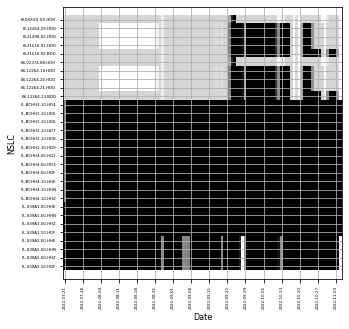

In [38]:
import matplotlib.pyplot as plt
def get_yticks(s):
    yticklabels = []
    yticks=[]
    for i, el in enumerate(s.to_numpy()):
        yticklabels.append(el)
        yticks.append(i)
    ystep = 1
    if len(yticks)>15:
        ystep=2  
    if len(yticks)>25:
        ystep=3
    if len(yticks)>40:
        ystep=int(len(yticks)*7/100)        
    yticks = yticks[0::ystep]
    yticklabels = yticklabels[0::ystep]
    return (yticks, yticklabels)

def ontime_plot(data,xticklabels,yticks,yticklabels):
    # make ontime plot
    plt.rc('axes', labelsize=8) 
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    #ax.imshow(data, aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
    ax.imshow(np.transpose(data), aspect='auto', cmap=plt.cm.gray, interpolation='nearest')
    #plt.xticks(np.arange(len(xticklabels)), xticklabels)
    plt.yticks(np.arange(len(xticklabels)), xticklabels)
    #ax.set_xticklabels(xticklabels, rotation = 90)
    ax.set_yticklabels(xticklabels, rotation = 0, )
    #plt.yticks(yticks, yticklabels)
    plt.xticks(yticks, yticklabels, rotation = 90)
    bottom, top = ax.set_ylim()
    ax.set_ylim(bottom+1, top-1)
    #plt.tight_layout()
    return (fig, ax)


# Aren't these really independent NSLC's rather than just stations?

Adf = availabilityDF.iloc[:,1:]/100
Adata = np.array(Adf, dtype=float) # convert dataframe to numpy array
xticklabels = Adf.columns
print(xticklabels)
(yticks, yticklabels) = get_yticks(availabilityDF['date'])
print(yticks)
(fig, ax) = ontime_plot(1.0-Adata,xticklabels,yticks,yticklabels)
ax.tick_params(axis='both', which='major', labelsize=4)
#fig.tight_layout()
plt.xlabel('Date')
plt.ylabel('NSLC')
plt.rc('font', size=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.grid('on')
plt.savefig('availability.pdf',dpi=300)


# 5. Read SDS archive and plot SDS archive for a rocket launch
Falcon 9 Block 5 | Starlink Group 4-35		September 24, 2022	SLC-40	23:32:10 UTC

In [ ]:
sdsclient = open_sds(SDS_TOP)
startt = obspy.UTCDateTime(2022,9,24,23,0,0)
endt = obspy.UTCDateTime(2022,9,24,23,59,59)
st = read_sds(sdsclient, startt, endt, trace_ids=trace_ids, speed=1)
print(st)
convert2units(st)
del sdsclient

st.plot(equal_scale=False);

In [ ]:
print(transducersDF)

In [6]:
MAXFILES=3
pklfiles = sorted(glob.glob(os.path.join(PKL_DIR,'*.pkl')))
lod=[]
for filenum, pklfile in enumerate(pklfiles[0:MAXFILES]):
    print(pklfile)
    df = pd.read_pickle(pklfile)
    #df=df.sort_values(by=['TIMESTAMP'])
    secs = np.array([x.timestamp() for x in df['TIMESTAMP']])
    secsdiff = secs[1:-1]-secs[0:-2]   
    for i in range(0,len(secsdiff)):
        thisdiff = secsdiff[i]
        if thisdiff > 0.012 or thisdiff < 0.008:
            print(thisdiff)
            mini = np.max(np.array([i-10,0]))
            maxi = np.min(np.array([i+10,len(secsdiff)]))
            print(df.iloc[mini:maxi])
    
    starttime=df.iloc[0]['TIMESTAMP']
    endtime=df.iloc[-1]['TIMESTAMP']
    timediff = (endtime - starttime)

    if timediff.seconds>4*60*60:
        #print('Problem likely with start time. Filter out all data more than 4 hours before end')
        df = df[df['TIMESTAMP']>endtime-pd.to_timedelta(4, unit='h')]
        df = df[df['TIMESTAMP']<=endtime]
        starttime=df.iloc[0]['TIMESTAMP']
        endtime=df.iloc[-1]['TIMESTAMP']
        timediff = (endtime - starttime)
    nrows=len(df.index)
    secs = np.array([x.timestamp() for x in df['TIMESTAMP']])
    secsdiff = secs[1:-1]-secs[0:-2]
    sample_interval = np.nanmedian(secsdiff)
    #sample_interval2 = timediff.seconds/(nrows-1)
    
    thisd = {}
    thisd['filename']=os.path.basename(pklfile)
    thisd['starttime']=starttime
    thisd['endtime']=endtime
    thisd['npts']=nrows
    thisd['nRECS']=df.iloc[-1]['RECORD']-df.iloc[0]['RECORD']+1
    thisd['Fs']=1/sample_interval
    lod.append(thisd)
lookuptableDF = pd.DataFrame(lod)
print(lookuptableDF)
lookuptableDF.to_csv('lookuptable.csv')

/Users/thompsong/Dropbox/DATA/KSC/KSC_Well_Seismoacoustic_Data/WellData/Converted/100hz_Baro_Sensors0.pkl
-0.07999992370605469
                     TIMESTAMP  RECORD  AirPressureShallow  AirPressureDeep
345022 2022-07-21 14:51:52.010  345022           14.766071        14.759005
345023 2022-07-21 14:51:52.020  345023           14.766808        14.761406
345024 2022-07-21 14:51:52.030  345024           14.765791        14.762508
345025 2022-07-21 14:51:52.040  345025           14.767477        14.763455
345026 2022-07-21 14:51:52.050  345026           14.767132        14.758930
345027 2022-07-21 14:51:52.060  345027           14.764173        14.760117
345028 2022-07-21 14:51:52.070  345028           14.767658        14.760881
345029 2022-07-21 14:51:52.080  345029           14.766362        14.763389
345030 2022-07-21 14:51:52.090  345030           14.767187        14.761286
345031 2022-07-21 14:51:52.100  345031           14.765789        14.761584
345032 2022-07-21 14:51:52.110  34503